# ARIMA Model for Time Series prediction

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

Load the data and simple preprocessing

In [2]:
data = pd.Series.from_csv('dj.csv', header=0, parse_dates=True)
data.index = data.index.map(lambda x: x + '-0')
data.index = pd.to_datetime(data.index, format='%Y-W%W-%w')
data.head()

1971-07-11    890.19
1971-07-18    901.80
1971-07-25    888.51
1971-08-01    887.78
1971-08-08    858.43
Name: dj, dtype: float64

## Our data: Index DJ from 1971 to 1974 years

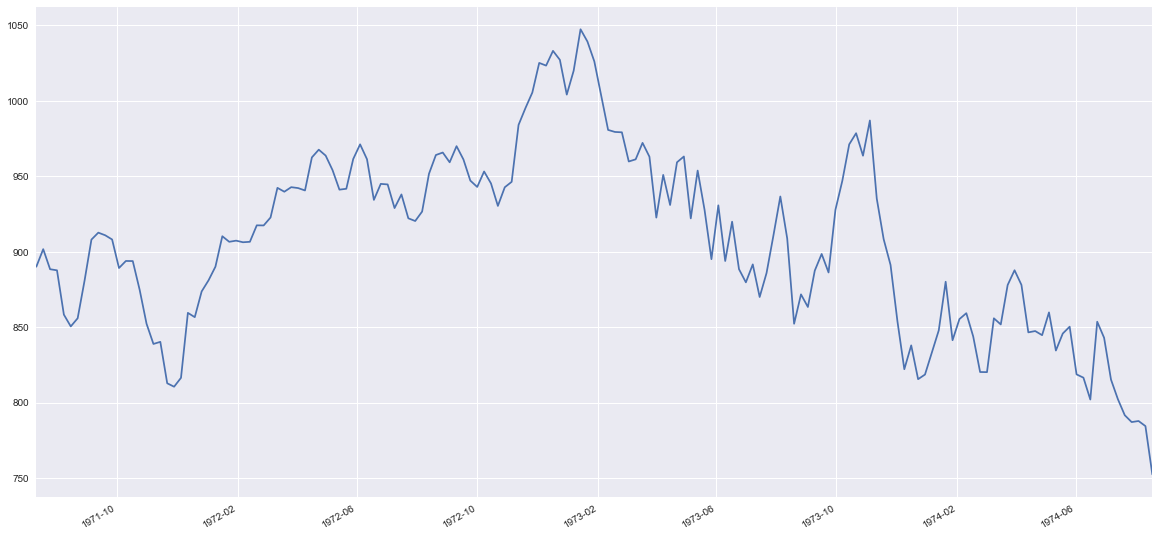

In [3]:
data.plot(figsize=(20, 10))

Let's look at different statistics:

In [4]:
itog = data.describe()
itog

count     162.000000
mean      907.484753
std        60.599919
min       752.580000
25%       857.170000
50%       908.645000
75%       951.572500
max      1047.490000
Name: dj, dtype: float64

## Check if stationary

We want our time series to be stationary. What should we check? 

Here we use Dickey–Fuller test

In [5]:
def check_stationary(_data):
    test = sm.tsa.adfuller(_data)
    print('adf: ', test[0])
    print('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['1%']: 
        print('Non-Stationary')
    else:
        print('Stationary')
        
def check_mean(_data):
    return pd.rolling_mean(_data, 50)

In [6]:
check_stationary(data)

adf:  -1.31462549849
p-value:  0.622454851559
Critical values:  {'1%': -3.4716333869322482, '5%': -2.8796651107461972, '10%': -2.5764336472358318}
Non-Stationary


### Rolling Mean

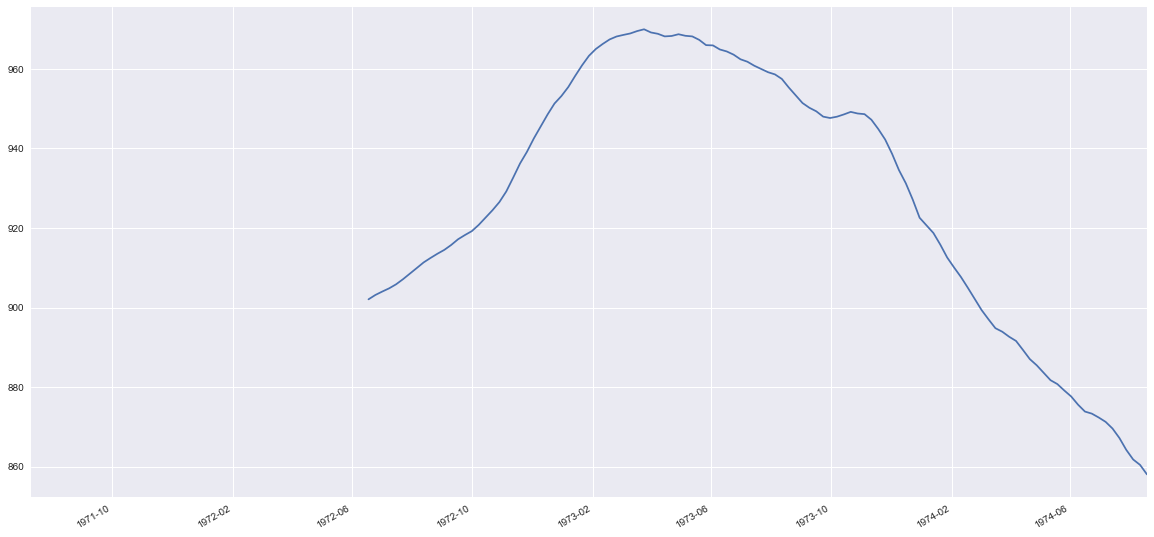

In [7]:
check_mean(data).plot(figsize=(20, 10))

Let's use diff of order 1

In [8]:
check_stationary(data.diff(periods=1).dropna())

adf:  -13.0252078812
p-value:  2.40758640374e-24
Critical values:  {'1%': -3.4718957209472654, '5%': -2.8797795410156253, '10%': -2.5764947265624998}
Stationary


In [9]:
otg1diff = data.diff(periods=1).dropna()

### New data

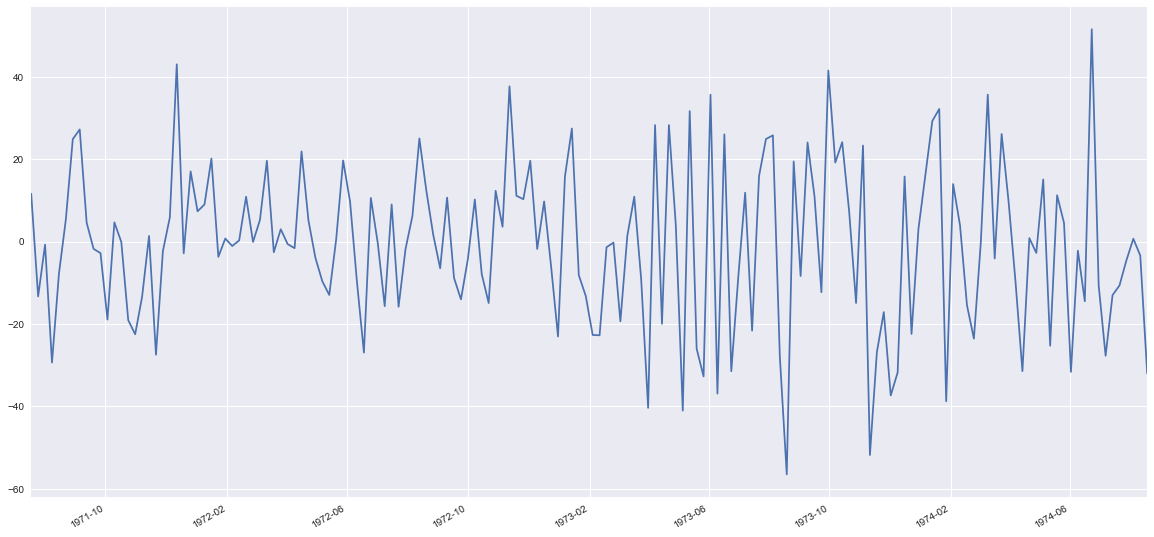

In [10]:
otg1diff.plot(figsize=(20, 10))

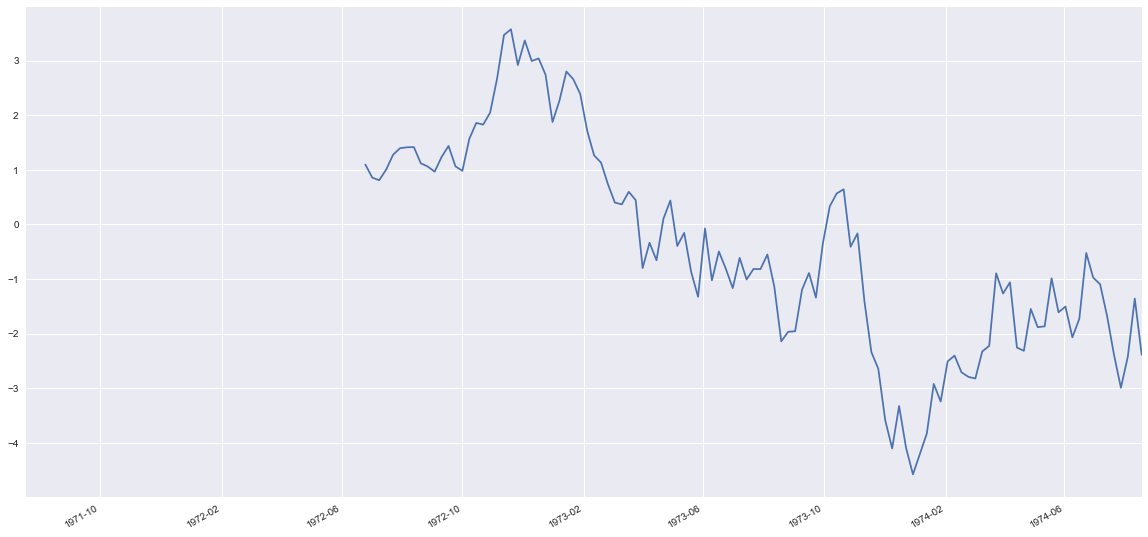

In [11]:
# check_mean(data).plot(figsize=(20, 10))
check_mean(otg1diff).plot(figsize=(20, 10))

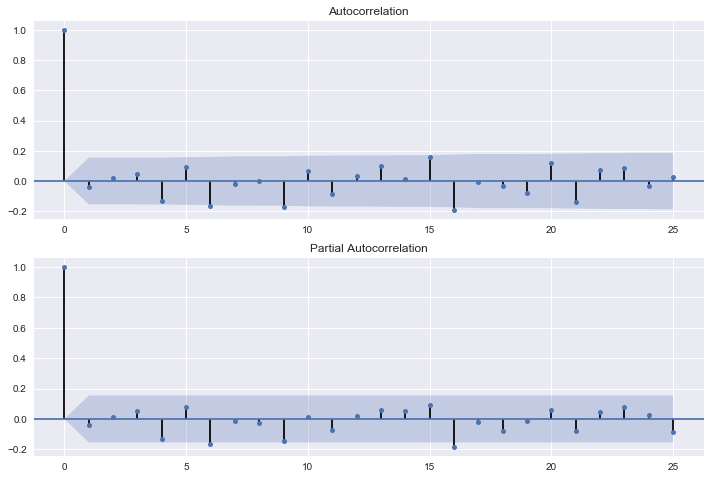

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(otg1diff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(otg1diff, lags=25, ax=ax2)

## Training of our model
We use ACF for determining q (MA), PACF for p (AR).

Train our model

In [13]:
data_head = data[:'1974-01-27']
data_test = data['1974-01-27':]

model = sm.tsa.ARIMA(data_head, order=(1,2,1), freq='W').fit(disp=0)

In [14]:
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D2.dj   No. Observations:                  131
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -579.700
Method:                       css-mle   S.D. of innovations             19.835
Date:                Fri, 03 Feb 2017   AIC                           1167.400
Time:                        01:04:28   BIC                           1178.900
Sample:                    07-25-1971   HQIC                          1172.073
                         - 01-27-1974                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const          -0.0399      0.044     -0.902      0.369        -0.127     0.047
ar.L1.D2.dj    -0.0253      0.089     -0.285      0.776        -0.199     0.148
ma.L1.D2.dj    -1.0000      0.021    -47.243    

# Prediction

In [15]:
pred = model.predict('1974-01-27', '1975-01-01', typ='levels')
pred.size

49

In [16]:
mean_absolute_error(data_test , pred[:30])

38.092538066075676

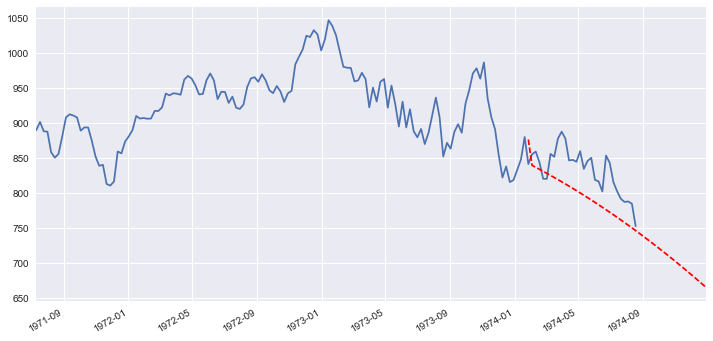

In [17]:
data.plot(figsize=(12,6))
pred.plot(style='r--')

# Prediction of Google stock price

In [18]:
from pandas_datareader.data import get_data_yahoo

In [19]:
google_stocks = get_data_yahoo('GOOGL')
start_date = '2014-12-03'
end_date = '2017-01-03'
google_stocks.head()



,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,626.950006,629.510005,624.240011,626.750011,3908400,313.688694
2010-01-05,627.180001,627.839984,621.540016,623.990017,6003300,312.307316
2010-01-06,625.860033,625.860033,606.360021,608.260035,7949400,304.434452
2010-01-07,609.400008,609.999993,592.649990,594.100015,12815700,297.347355
2010-01-08,592.000005,603.250036,589.110015,602.020005,9439100,301.311314


In [20]:
google_stocks = google_stocks.Close

google_train = google_stocks[start_date:end_date]
google_test = google_stocks[end_date:]

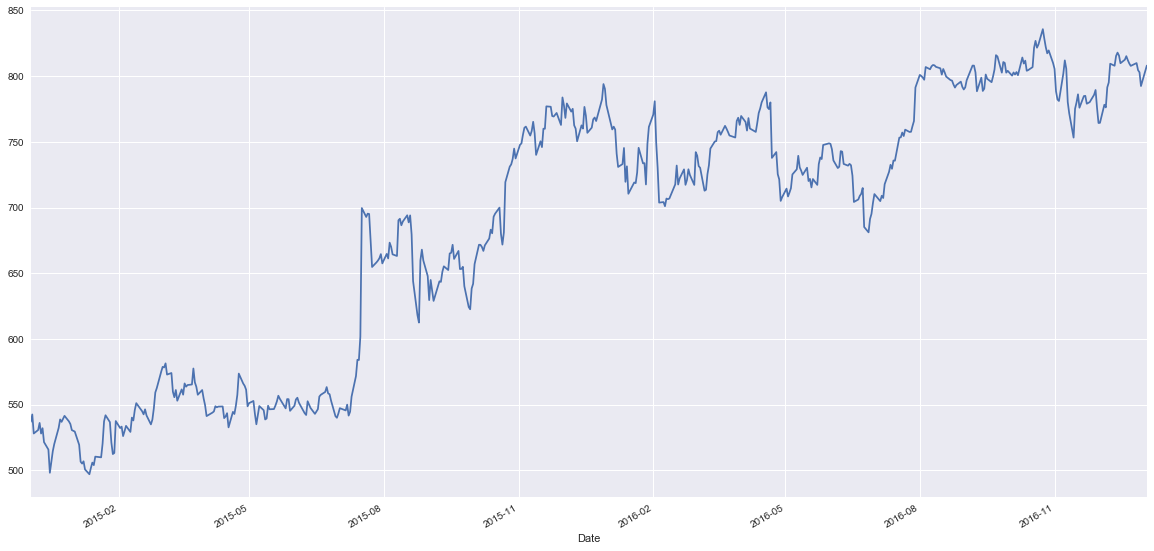

In [21]:
google_train.plot(figsize=(20, 10))

## Check if data is stationary

In [22]:
check_stationary(google_train)

adf:  -1.33738451344
p-value:  0.611900121124
Critical values:  {'1%': -3.4429638415440995, '5%': -2.8671034821276349, '10%': -2.5697331315829222}
Non-Stationary


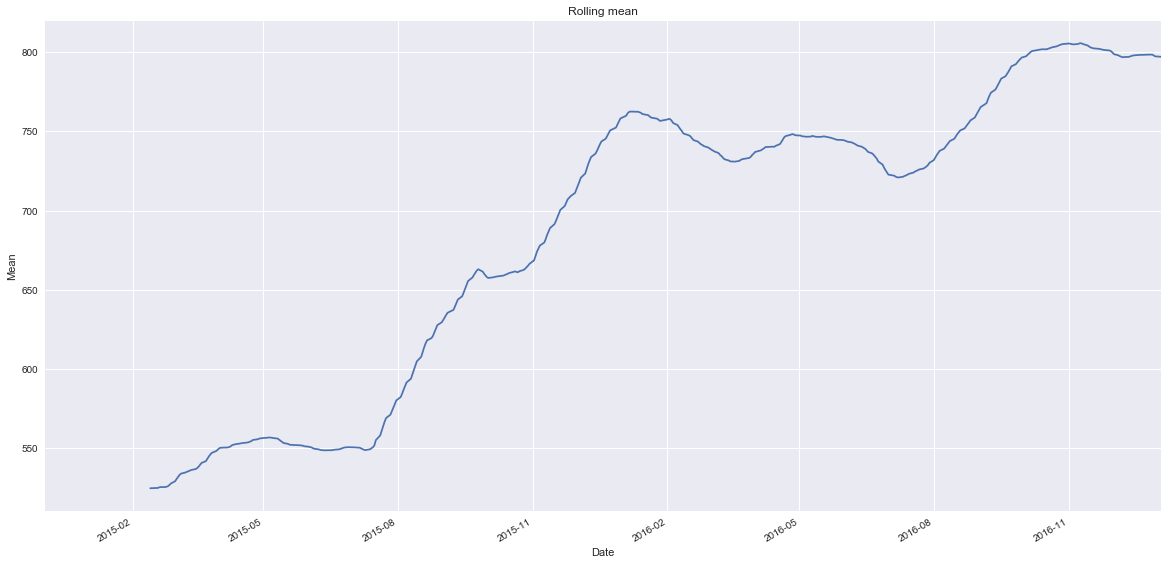

In [23]:
check_mean(google_train).plot(figsize=(20, 10))
plt.title('Rolling mean')
plt.ylabel('Mean')

In [24]:
check_stationary(google_train.diff(periods=1).dropna())

adf:  -14.1463988752
p-value:  2.20031991965e-26
Critical values:  {'1%': -3.4429638415440995, '5%': -2.8671034821276349, '10%': -2.5697331315829222}
Stationary


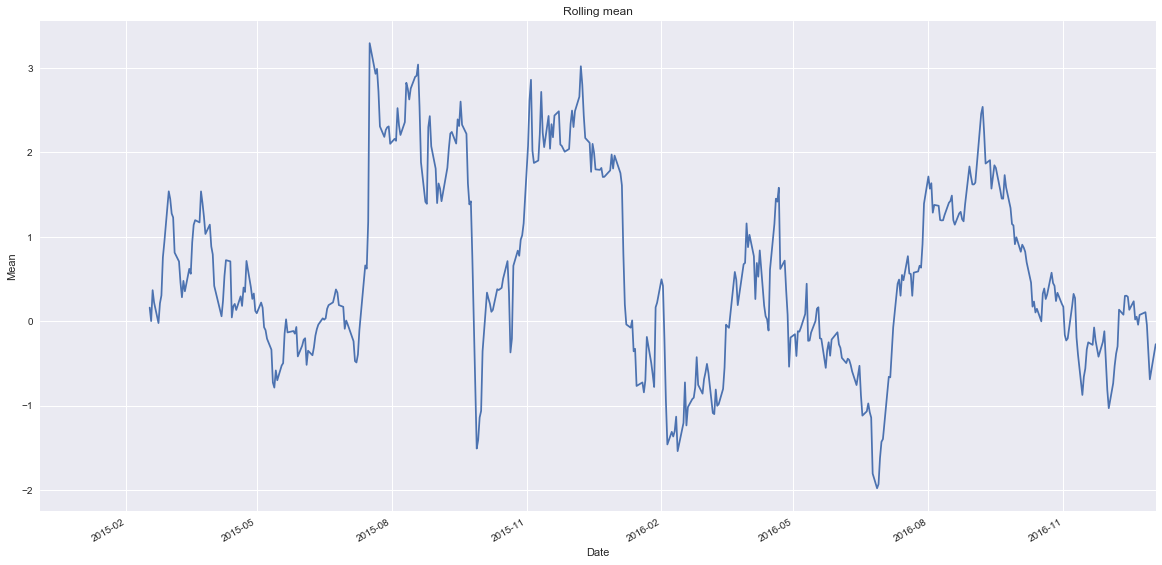

In [25]:
check_mean(google_train.diff(periods=1).dropna()).plot(figsize=(20, 10))
plt.title('Rolling mean')
plt.ylabel('Mean')

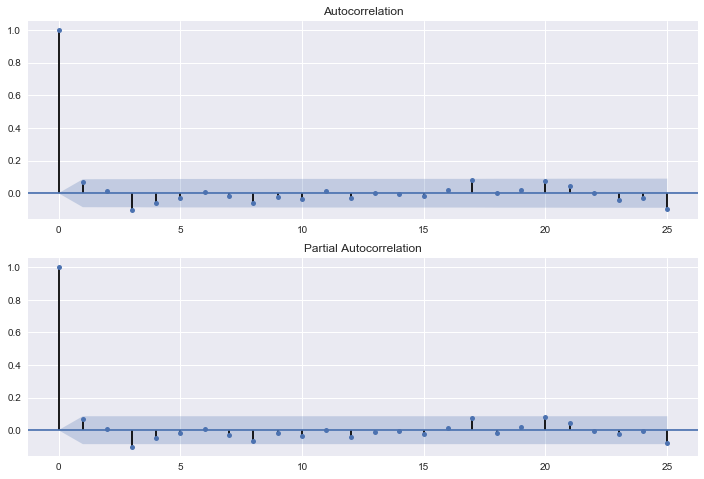

In [26]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(google_train.diff(periods=1).dropna(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(google_train.diff(periods=1).dropna(), lags=25, ax=ax2)

In [27]:
model = sm.tsa.ARIMA(google_train, order=(1,2,1), freq='D').fit(disp=0)

In [28]:
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  523
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1967.703
Method:                       css-mle   S.D. of innovations             10.356
Date:                Fri, 03 Feb 2017   AIC                           3943.405
Time:                        01:04:33   BIC                           3960.444
Sample:                    12-05-2014   HQIC                          3950.078
                         - 01-03-2017                                         
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const             -0.0006      0.003     -0.174      0.862        -0.007     0.006
ar.L1.D2.Close     0.0691      0.044      1.579      0.115        -0.017     0.155
ma.L1.D2.Close    -1.0000      0.005

In [29]:
pred = model.predict(end_date, '2017-02-10', typ='levels')

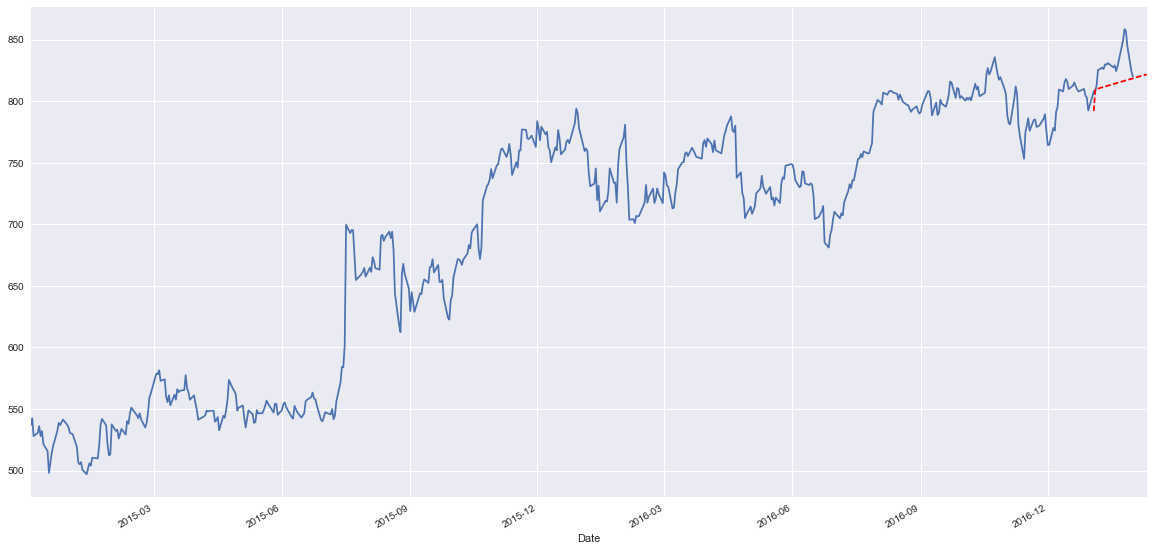

In [30]:
google_stocks[start_date:'2017-01-31'].plot(figsize=(20,10))
pred.plot(style='r--')

# Предсказание курса акций APPLE с помощью модели ARIMA
Целью является изучить поведение алгоритмов ARIMA при предсказании курса.

In [31]:
from pandas_datareader.data import get_data_yahoo
apple_stocks = get_data_yahoo('AAPL')
apple_stocks.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,213.429998,214.499996,212.380001,214.009998,123432400,27.847252
2010-01-05,214.599998,215.589994,213.249994,214.379993,150476200,27.895396
2010-01-06,214.379993,215.230000,210.750004,210.969995,138040000,27.451683
2010-01-07,211.750000,212.000006,209.050005,210.580000,119282800,27.400936
2010-01-08,210.299994,212.000006,209.060005,211.980005,111902700,27.583106


## Загрузка данных
Мы загрузили данные, давайте теперь оставим только цену на момент закрытия, разделим нашу выборку на train и test (в качестве теста используйте данные с 15 января 2017 года). Постройте графики обеих выборок. Стационарен ли данный ряд?

## Стационарность
Ислледуйте на стационарность:
* Дисперсия (преобразование Бокса-Кокса)
* Дифференцирования какого порядка стоит рассматривать?

## Определение гиперпараметров модели

* Автокорреляция и частичная автокорреляция для определения параметров 
* AIC и BIC
* Метрика качества (например, MAE) на прошлых данных

В качестве помощи в подборе гиперпараметров предлагается использовать библиотеку hyperopt (для Random Search).

## Построение финальной модели и её тестирование
Продемонстрируйте предсказание финальной модели, покажите её MAE и MSE на тестовом множестве